# Homework 5

# Задача №1 - Можете ли вы отличить сорняки от рассады?

Теперь приступим к задаче классификации на картинках. Реализуйте программу, которая определяет тип рассады на изображении. 

Для того, чтобы определить характерные особенности каждого типа рассады, у вас есть train. Train это папка, в которой картинки уже классифицированы и лежат в соответствующих папках. Исходя из этой информации можете найти признаки, присущие конкретному растению.

Проверка вашего решения будет на происходить на test. В папке test уже нет метки класса для каждой картинки. 

[Ссылка на Яндекс-диск](https://yadi.sk/d/0Zzp0klXT0iRmA), все картинки тут.

Примеры изображений для теста:
<table><tr>
    <td> <img src="https://i.ibb.co/tbqR37m/fhj.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/6yL3Wmt/sfg.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/pvn7NvF/asd.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [1]:
"""Plant species classification using SIFT features and Bag of Visual Words."""

import os
from glob import glob
from typing import List, Dict, Tuple, Any, Optional

import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm


def GetSIFTDescriptors(image_path: str) -> Optional[np.ndarray]:
    """Extracts SIFT descriptors from an image with green plant masking.
    
    Args:
        image_path: Path to the input image.
    
    Returns:
        Numpy array of SIFT descriptors (N x 128) or None if no features found.
    """
    img = cv2.imread(image_path, cv2.IMREAD_COLOR_RGB)
    if img is None:
        return None

    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(img_hsv, (35, 50, 50), (85, 255, 255))
    gray_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) * mask

    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(gray_img, None)
    
    return descriptors


def BuildFeatureVocabulary(
    train_image_paths: List[str],
    feature_size: int,
    random_state: int = 42
) -> KMeans:
    """Builds visual vocabulary using K-means clustering on SIFT features.
    
    Args:
        train_image_paths: List of paths to training images.
        feature_size: Number of clusters for K-means.
        random_state: Random seed for reproducibility.
    
    Returns:
        Trained KMeans model representing the visual vocabulary.
    """
    all_descriptors = []

    for path in tqdm(train_image_paths, desc="Extracting SIFT features"):
        descriptors = GetSIFTDescriptors(path)
        if descriptors is not None:
            all_descriptors.append(descriptors)

    if not all_descriptors:
        raise ValueError("No SIFT descriptors found in training images.")

    all_descriptors = np.vstack(all_descriptors)
    kmeans = KMeans(n_clusters=feature_size, random_state=random_state)
    kmeans.fit(all_descriptors)
    
    return kmeans


def CreateFeatureArray(
    image_path: str,
    kmeans: KMeans,
    feature_size: int
) -> np.ndarray:
    """Creates a feature array (histogram) for an image using visual words.
    
    Args:
        image_path: Path to the input image.
        kmeans: Trained KMeans model for visual words.
        feature_size: Number of visual words.
    
    Returns:
        Normalized histogram of visual words (feature array).
    """
    descriptors = GetSIFTDescriptors(image_path)
    if descriptors is None:
        return np.zeros(feature_size)

    visual_words = kmeans.predict(descriptors)
    hist, _ = np.histogram(visual_words, bins=feature_size, range=(0, feature_size))
    hist = hist.astype(np.float32)

    if hist.sum() != 0:
        hist /= hist.sum()
    
    return hist


def LoadImagePathsAndLabels(
    data_dir: str
) -> Tuple[List[str], List[int], List[str]]:
    """Loads image paths and corresponding labels from directory structure.
    
    Args:
        data_dir: Directory containing subdirectories for each class.
    
    Returns:
        Tuple of (image_paths, labels, class_names)
    """
    class_names = sorted(os.listdir(data_dir))
    image_paths = []
    labels = []

    for label, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        for img_path in glob(os.path.join(class_path, "*.png")):
            image_paths.append(img_path)
            labels.append(label)
    
    return image_paths, labels, class_names


def TrainPlantClassifier(
    train_dir: str,
    feature_size: int = 100,
    random_state: int = 42
) -> Tuple[Pipeline, KMeans, List[str]]:
    """Trains a plant species classifier using SIFT and BoVW approach.
    
    Args:
        train_dir: Directory containing training images.
        feature_size: Number of visual words.
        random_state: Random seed for reproducibility.
    
    Returns:
        Tuple of (trained classifier, visual vocabulary, class names)
    """
    print("=== Loading training data ===")
    train_image_paths, train_labels, class_names = LoadImagePathsAndLabels(train_dir)

    print("\n=== Building visual vocabulary ===")
    kmeans = BuildFeatureVocabulary(train_image_paths, feature_size, random_state)

    print("\n=== Creating training features ===")
    x_train = []
    for path in tqdm(train_image_paths, desc="Processing training images"):
        feature_vector = CreateFeatureArray(path, kmeans, feature_size)
        x_train.append(feature_vector)
    
    x_train = np.array(x_train)
    y_train = np.array(train_labels)

    print("\n=== Training classifier ===")
    classifier = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=random_state))
    ])
    classifier.fit(x_train, y_train)
    print("\n=== Training finished ===")
    return classifier, kmeans, class_names


def TestPlantClassifier(
    test_dir: str,
    classifier: Pipeline,
    kmeans: KMeans,
    class_names: List[str],
    feature_size: int
) -> Tuple[List[Dict[str, Any]], List[int]]:
    """Tests the trained plant classifier on new images.
    
    Args:
        test_dir: Directory containing test images.
        classifier: Trained classifier pipeline.
        kmeans: Trained visual vocabulary.
        class_names: List of class names.
        feature_size: Number of visual words.
    
    Returns:
        Tuple of (detailed results, predicted labels)
    """
    test_image_paths = glob(os.path.join(test_dir, "*.png"))
    results = []
    predictions = []

    print(f"\n=== Testing on {len(test_image_paths)} images ===")
    for img_path in tqdm(test_image_paths, desc="Processing test images"):
        feature_vector = CreateFeatureArray(img_path, kmeans, feature_size)
        probabilities = classifier.predict_proba([feature_vector])[0]
        
        top_class_idx = np.argmax(probabilities)
        top_class_name = class_names[top_class_idx]
        top_confidence = probabilities[top_class_idx]

        predictions.append(top_class_idx)
        results.append({
            'image_path': img_path,
            'predictions': list(zip(class_names, probabilities)),
            'top_class': top_class_name,
            'top_class_idx': top_class_idx,
            'confidence': top_confidence
        })
    
    return results, predictions


def PrintTestResults(
    test_results: List[Dict[str, Any]],
    y_true: List[int],
    y_pred: List[int],
    is_detailed: bool
) -> None:
    """Prints test results and evaluation metrics.
    
    Args:
        test_results: Detailed prediction results.
        y_true: Ground truth labels.
        y_pred: Predicted labels.
        is_detailed: Detailed Results Or Not.
    """
    if(is_detailed):
        print("\n=== Detailed Test Results ===")
        for result in test_results:
            print(f"\nImage: {os.path.basename(result['image_path'])}")
            print(f"Predicted: {result['top_class']} (confidence: {result['confidence']:.2f})")
            print("Class probabilities:")
            for class_name, prob in sorted(result['predictions'], key=lambda x: -x[1]):
                print(f"  {class_name}: {prob:.4f}")

    print("\n=== Evaluation Metrics ===")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")


In [2]:
train_dir = os.path.join("plants_data", "train")
test_dir = os.path.join("plants_data", "test")
feature_size = 100
random_state = 42

# Ground truth labels
y_test = np.array([0, 0, 1, 1, 0, 0, 2, 3, 1, 0, 1, 1, 0, 3, 2, 3, 2, 3, 0, 3, 
        2, 2, 3, 1, 3, 2, 2, 1, 3, 3, 0, 2, 0, 0, 1, 2, 3, 2, 1, 1])

# Train the model
classifier, visual_vocab, class_names = TrainPlantClassifier(
    train_dir, feature_size, random_state)


=== Loading training data ===

=== Building visual vocabulary ===


Extracting SIFT features: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s]



=== Creating training features ===


Processing training images: 100%|██████████| 20/20 [00:05<00:00,  3.98it/s]


=== Training classifier ===

=== Training finished ===


In [3]:
# Test the model
test_results, y_pred = TestPlantClassifier(
    test_dir, classifier, visual_vocab, class_names, feature_size)

# Print results
PrintTestResults(test_results, y_test, y_pred, False)


=== Testing on 40 images ===


Processing test images: 100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


=== Evaluation Metrics ===
Accuracy: 1.0000


# Задача №2 - Собери пазл (2.0).

Даны кусочки изображения, ваша задача склеить пазл в исходную картинку. 

Условия:
* Дано исходное изображение для проверки, использовать собранное изображение в самом алгоритме нельзя;
* Картинки имеют друг с другом пересечение;
* После разрезки кусочки пазлов не были повернуты или отражены;
* НЕЛЬЗЯ выбрать опорную картинку для сбора пазла, как это было в homework 3
* В процессе проверки решения пазлы могут быть перемешаны, т.е. порядок пазлов в проверке может отличаться от исходного 

Изображения расположены по [ссылке](https://disk.yandex.ru/d/XtpawH1sV9UDlg).

Примеры изображений:
<img src="puzzle/su_fighter.jpg" alt="Drawing" style="width: 300px;"/>
<table><tr>
    <td> <img src="puzzle/su_fighter_shuffle/0.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/1.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/2.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="puzzle/su_fighter_shuffle/3.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

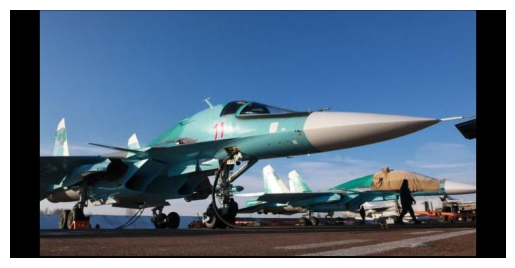

In [4]:
import matplotlib.pyplot as plt

def find_offset_ransac(points, transformed_points):
    """Находит оптимальное смещение между точками методом RANSAC"""
    best_offset = None
    best_loss = np.inf  # Инициализация наилучшей ошибки бесконечностью
    loss_f = lambda x1, x2: np.linalg.norm(x1 - x2)  # Функция потерь (евклидово расстояние)
    
    # Перебираем все возможные смещения
    for point, transformed_point in zip(points, transformed_points):
        offset = (transformed_point - point)[:2]  # Вычисляем смещение
        transformation = np.eye(3)  # Единичная матрица 3x3
        transformation[:2, 2] = offset  # Установка смещения в последний столбец
        transformed_points = (transformation @ points.T).T  # Умножение матрицы на точки
        transformed_points = np.divide(transformed_points.T, transformed_points[:, 2]).T  # Нормализация
        tmp_loss = loss_f(transformed_points, transformed_points)  # Вычисляем ошибку
        
        # Сохраняем лучшее смещение
        if tmp_loss < best_loss:
            best_loss = tmp_loss
            best_offset = offset
    return best_offset

def get_shift(first, second):
    """Находит смещение между двумя изображениями с помощью SIFT и FLANN"""
    # Настройки для SIFT детектора
    nfetures = first.size // second.size * 1000  # Динамическое количество фич
    
    hyp_params2 = dict(
        nfeatures=1000,
        nOctaveLayers=7,
        contrastThreshold=0.04,
        edgeThreshold=10,
        sigma=1.6
    ) 
    
    hyp_params1 = dict(
        nfeatures=nfetures,
        nOctaveLayers=4,
        contrastThreshold=0.04,
        edgeThreshold=10,
        sigma=1.6
    )
    
    # Инициализация SIFT детекторов
    sift2 = cv2.SIFT_create(**hyp_params2)
    sift1 = cv2.SIFT_create(**hyp_params1)
    
    # Настройка FLANN матчера
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=2, trees=15)
    search_params = dict(checks=150)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Поиск ключевых точек и дескрипторов
    kp1, des1 = sift1.detectAndCompute(first, None)
    kp2, des2 = sift2.detectAndCompute(second, None)

    if des2 is None or des1 is None:
        return None
    
    try:
        # Поиск соответствий между дескрипторами
        matches = flann.knnMatch(des1, des2, k=2)
        ratio_thresh = 0.2
        good_matches = []
        # Фильтрация хороших соответствий
        for m, n in matches:
            if m.distance < ratio_thresh * n.distance:
                good_matches.append(m)
    except:
        return None
    
    if len(good_matches) == 0:
        return None
    
    # Преобразование точек в однородные координаты
    points = np.array([[kp1[m.queryIdx].pt[1], kp1[m.queryIdx].pt[0], 1] for m in good_matches])
    transformed_points = np.array([[kp2[m.trainIdx].pt[1], kp2[m.trainIdx].pt[0], 1] for m in good_matches])
    
    # Нахождение оптимального смещения
    shift = find_offset_ransac(transformed_points, points)
    if shift is not None:
        shift[0] = round(shift[0])  # Округление координат
        shift[1] = round(shift[1])
    return shift

def are_shifted(first, second):
    """Проверяет, являются ли изображения смещенными версиями друг друга"""
    shift = get_shift(first, second)
    return shift is not None

def stitch_images_right_down(left, right, shift):
    """Сшивает изображения, предполагая что right смещено вниз и вправо относительно left"""
    # Вычисление размеров нового изображения
    new_shape = [max(left.shape[0], right.shape[0] + shift[0]), 
                max(left.shape[1], right.shape[1] + shift[1]), 
                3]
    new_image = np.zeros(shape=new_shape)
    
    # Размещение изображений с учетом смещения
    new_image[0:left.shape[0], 0:left.shape[1], :] = left
    new_image[shift[0]:right.shape[0]+shift[0], shift[1]:right.shape[1]+shift[1], :] = right
    
    return new_image.astype(np.uint8)

def stitch_images(first, second):
    """Основная функция для сшивания двух изображений"""
    shift = get_shift(first, second)
    if shift is None:
        return None
    
    shift = np.array(shift, dtype=np.int32)
    
    # Обработка 4 возможных случаев смещения
    if shift[0] >= 0 and shift[1] >= 0:
        result = stitch_images_right_down(first, second, shift)
    elif shift[0] >= 0 and shift[1] < 0:
        shift[1] *= -1
        first = np.pad(first, ((0, 0), (shift[1], 0), (0, 0)))
        shift[1] = 0
        result = stitch_images_right_down(first, second, shift)
    elif shift[0] < 0 and shift[1] >= 0:
        shift[0] *= -1
        first = np.pad(first, ((shift[0], 0), (0, 0), (0, 0)))
        shift[0] = 0
        result = stitch_images_right_down(first, second, shift)
    elif shift[0] < 0 and shift[1] < 0:
        shift[0] *= -1
        shift[1] *= -1
        first = np.pad(first, ((shift[0], 0), (shift[1], 0), (0, 0)))
        shift[0] = 0
        shift[1] = 0
        result = stitch_images_right_down(first, second, shift)
    
    return result

# Основной блок выполнения
image_paths = []
puzzle_dir = 'puzzle_data/su_fighter_shuffle'
# puzzle_dir = 'puzzle_data/china_shuffle'
# puzzle_dir = 'puzzle_data/home_shuffle' # не работает
image_paths.extend(glob(os.path.join(puzzle_dir, "*.jpg"))) # Загрузка путей к изображениям

images = [cv2.imread(image_path) for image_path in image_paths]  # Чтение изображений

index = [*range(len(images))]  # Создание списка индексов
base_image = images[0]  # Базовое изображение для сборки
index.remove(0)  # Удаление базового изображения из списка индексов

# Основной цикл сборки пазла
while len(index) > 0:
    breaked = False
    for i in index:
        img = images[i]
        if are_shifted(base_image, img):  # Проверка, можно ли сшить изображения
            breaked = True
            base_image = stitch_images(base_image, img)  # Сшивание изображений
            index.remove(i)  # Удаление использованного изображения
            break
    
    if not breaked:  # Если не удалось сшить ни с одним изображением
        print("can't solve puzzle")
        break

# Отображение результата
base_image = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)  # Конвертация в RGB
plt.imshow(base_image)
plt.axis('off')
plt.show()